# **DATA PREPROCESSING BASED ON EDA INSIGHTS**

This notebook implements preprocessing steps based on the comprehensive EDA findings and recommendations. We'll follow the evidence-based approach from the EDA report to ensure our preprocessing aligns with the data patterns discovered.
Based on the EDA report, we will:
 Final Preprocessing Pipeline (Suggested Order)

1. **Feature Engineering** - `Age_of_estab, Annual_wage, wage_per_hour, wage_per_week, wage_per_month, wage_per_year, need_training-has_exp, need_training_no_exp, region_median_wage, wage_vs_region`.
2. **Handle Skewed Variables(Log Tranformation)** - `No_of_employees, year_of_estab, and prevailing_wage`.
3. **Encoding categorical and Ordinal columns** - `binary conding on all the yes and No columns, `
4. **Splitting into target and Features / Feature Selection**
6. **Target Handling** - Class imbalance using SMOTE
7. **Scaling** - RobustScaler
8. **Feature Importance Analysis**
**Key EDA Evidence to Implement**
- **Skewed variables**:  (log-transform)
- **Feature engineering**: `Age_of_estab, wage_per_hour, age_per_year`.




#### **. Import Libraries and Load Data**


In [2]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

# Preprocessing libraries
from sklearn.preprocessing import RobustScaler, LabelEncoder,OrdinalEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix

# Statistical libraries
from scipy import stats
from scipy.stats import zscore, skew

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [3]:
#load your dataset
df = pd.read_csv("Easy_Vias_clean_data.csv")

# create a copy
df_copy = df.copy()

#### **1. Feature Engineering**
 **Feature Engineering** - `Age_of_estab, Annual_wage, wage_per_hour, wage_per_week, wage_per_month, wage_per_year, need_training-has_exp, need_training_no_exp, region_median_wage, wage_vs_region`.

In [4]:
df.columns

Index(['continent', 'education_of_employee', 'has_job_experience',
       'requires_job_training', 'no_of_employees', 'yr_of_estab',
       'region_of_employment', 'prevailing_wage', 'unit_of_wage',
       'full_time_position', 'case_status'],
      dtype='object')

In [5]:
# create column for age of the company
current_year = datetime.now().year  #get the current year

df["age_establishment"] = current_year - df["yr_of_estab"] 
df["age_establishment"].head(3)

0    18
1    23
2    17
Name: age_establishment, dtype: int64

In [6]:
df

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status,age_establishment
0,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied,18
1,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified,23
2,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied,17
3,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied,128
4,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified,20
...,...,...,...,...,...,...,...,...,...,...,...,...
25475,Asia,Bachelor's,Y,Y,2601,2008,South,77092.5700,Year,Y,Certified,17
25476,Asia,High School,Y,N,3274,2006,Northeast,279174.7900,Year,Y,Certified,19
25477,Asia,Master's,Y,N,1121,1910,South,146298.8500,Year,N,Certified,115
25478,Asia,Master's,Y,Y,1918,1887,West,86154.7700,Year,Y,Certified,138


In [7]:
#Calculate the annual wage
unit_map ={
    "Hour": 2080, #40hrs * 52weeks
    "Week": 52,
    "Month": 12,
    "Year":1
}
df["annual_wage"] = df["prevailing_wage"] * df["unit_of_wage"].map(unit_map)
df["annual_wage"].head(5)
# calculate wages per hour, week,month, year 
df["wage_per_hour"] = df["annual_wage"]/2080
df["wage_per_week"] = df["annual_wage"]/52
df["wage_per_month"] = df["annual_wage"]/12


In [8]:
# creates columnns needs_traing_has_experience & needs_traing_no_experience
df["needs_traing_has_experience"] = ((df["has_job_experience"] == "Y") & (df["requires_job_training"] == "Y")).astype(int)
df["needs_traing_no_experience"] = ((df["has_job_experience"] == "N") & (df["requires_job_training"] == "Y")).astype(int)
df.head(5)

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status,age_establishment,annual_wage,wage_per_hour,wage_per_week,wage_per_month,needs_traing_has_experience,needs_traing_no_experience
0,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied,18,1231782.032,592.202900,23688.116000,102648.502667,0,0
1,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified,23,83425.650,40.108486,1604.339423,6952.137500,0,0
2,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied,17,122996.860,59.133106,2365.324231,10249.738333,0,1
3,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied,128,83434.030,40.112514,1604.500577,6952.835833,0,0
4,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified,20,149907.390,72.070861,2882.834423,12492.282500,0,0


In [9]:
# create column "region_median_wage"
df["region_median_wage"] = df.groupby("region_of_employment")["annual_wage"].transform("median")
df.head(2)

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status,age_establishment,annual_wage,wage_per_hour,wage_per_week,wage_per_month,needs_traing_has_experience,needs_traing_no_experience,region_median_wage
0,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied,18,1231782.032,592.202900,23688.116000,102648.502667,0,0,73867.56
1,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified,23,83425.650,40.108486,1604.339423,6952.137500,0,0,81428.85


In [10]:
# wage vs region creates a ratio of How an employee’s wage compares to their region’s typical (median) wage.
df["wage_vs_region"] = df["annual_wage"] / df["region_median_wage"] 
df.head(2)

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status,age_establishment,annual_wage,wage_per_hour,wage_per_week,wage_per_month,needs_traing_has_experience,needs_traing_no_experience,region_median_wage,wage_vs_region
0,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied,18,1231782.032,592.202900,23688.116000,102648.502667,0,0,73867.56,16.675548
1,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified,23,83425.650,40.108486,1604.339423,6952.137500,0,0,81428.85,1.024522


#### **2. Log-Transform Skewed Variables (EDA Recommendation)**

In [11]:
# # df["wage_per_hour"]
# df["wage_per_week"]
# # df["wage_per_month"]
df["region_median_wage"].skew()

np.float64(0.359680639082064)

In [12]:
def handle_skewed_data(df):
    """ Handles the skewness of the data"""
    skewed_column = ['annual_wage','wage_per_hour','wage_per_week','wage_per_month','wage_vs_region','age_establishment']
    for col in skewed_column:
            # Check if variable has zero or negative values
            min_val = df[col].min()
            if min_val <= 0:
                # Use log1p for variables with zeros
                df[f"{col}_log"] = np.log1p(df[col])
                print(f"{col}: Applied  loglp Transformation(had {min_val:.3f} minimum value)")
            else:
            # Use log for positive values only
                df[f"{col}_log"] = np.log(df[col])
                print(f" {col}: Applied log transformation")

            # Check skewness before and after
            original_skew = skew(df[col])
            transformed_skew = skew(df[f'{col}_log'])
            print(f"Original skewness: {original_skew:.3f} → Transformed skewness: {transformed_skew:.3f}")
    return df

In [13]:
handle_skewed_data(df)

 annual_wage: Applied log transformation
Original skewness: 8.976 → Transformed skewness: 0.014
 wage_per_hour: Applied log transformation
Original skewness: 8.976 → Transformed skewness: 0.014
 wage_per_week: Applied log transformation
Original skewness: 8.976 → Transformed skewness: 0.014
 wage_per_month: Applied log transformation
Original skewness: 8.976 → Transformed skewness: 0.014
 wage_vs_region: Applied log transformation
Original skewness: 9.194 → Transformed skewness: 0.043
 age_establishment: Applied log transformation
Original skewness: 2.037 → Transformed skewness: 0.812


,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,...,needs_traing_has_experience,needs_traing_no_experience,region_median_wage,wage_vs_region,annual_wage_log,wage_per_hour_log,wage_per_week_log,wage_per_month_log,wage_vs_region_log,age_establishment_log
0,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,...,0,0,73867.56,16.675548,14.023972,6.383849,10.072729,11.539066,2.813943,2.890372
1,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,...,0,0,81428.85,1.024522,11.331711,3.691588,7.380467,8.846804,0.024226,3.135494
2,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,...,0,1,73867.56,1.665100,11.719914,4.079791,7.768670,9.235007,0.509885,2.833213
3,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,...,0,0,73867.56,1.129508,11.331812,3.691688,7.380568,8.846905,0.121782,4.852030
4,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,...,0,0,84812.35,1.767518,11.917773,4.277650,7.966529,9.432866,0.569577,2.995732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25475,Asia,Bachelor's,Y,Y,2601,2008,South,77092.5700,Year,Y,...,1,0,84812.35,0.908978,11.252762,3.612639,7.301518,8.767856,-0.095434,2.833213
25476,Asia,High School,Y,N,3274,2006,Northeast,279174.7900,Year,Y,...,0,0,81428.85,3.428451,12.539593,4.899470,8.588350,10.054687,1.232108,2.944439
25477,Asia,Master's,Y,N,1121,1910,South,146298.8500,Year,N,...,0,0,84812.35,1.724971,11.893407,4.253284,7.942163,9.408500,0.545210,4.744932
25478,Asia,Master's,Y,Y,1918,1887,West,86154.7700,Year,Y,...,1,0,73867.56,1.166341,11.363901,3.723777,7.412657,8.878994,0.153872,4.927254


 #### **3.Encode categorical variables (Label, Binary Ordinal)**

In [14]:
# Binary encode columns with yes and no
for col in ["full_time_position","has_job_experience","requires_job_training"]:
    df[col] = (df[col] == "Y").astype(int)

In [15]:
df.head(20)

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,...,needs_traing_has_experience,needs_traing_no_experience,region_median_wage,wage_vs_region,annual_wage_log,wage_per_hour_log,wage_per_week_log,wage_per_month_log,wage_vs_region_log,age_establishment_log
0,Asia,High School,0,0,14513,2007,West,592.2029,Hour,1,...,0,0,73867.56,16.675548,14.023972,6.383849,10.072729,11.539066,2.813943,2.890372
1,Asia,Master's,1,0,2412,2002,Northeast,83425.6500,Year,1,...,0,0,81428.85,1.024522,11.331711,3.691588,7.380467,8.846804,0.024226,3.135494
2,Asia,Bachelor's,0,1,44444,2008,West,122996.8600,Year,1,...,0,1,73867.56,1.665100,11.719914,4.079791,7.768670,9.235007,0.509885,2.833213
3,Asia,Bachelor's,0,0,98,1897,West,83434.0300,Year,1,...,0,0,73867.56,1.129508,11.331812,3.691688,7.380568,8.846905,0.121782,4.852030
4,Africa,Master's,1,0,1082,2005,South,149907.3900,Year,1,...,0,0,84812.35,1.767518,11.917773,4.277650,7.966529,9.432866,0.569577,2.995732
5,Asia,Master's,1,0,2339,2012,South,78252.1400,Year,1,...,0,0,84812.35,0.922650,11.267691,3.627568,7.316448,8.782785,-0.080505,2.564949
6,Asia,Bachelor's,0,0,4985,1994,South,53635.3900,Year,1,...,0,0,84812.35,0.632401,10.889964,3.249841,6.938721,8.405058,-0.458232,3.433987
7,North America,Bachelor's,1,0,3035,1924,West,418.2298,Hour,1,...,0,0,73867.56,11.776726,13.676154,6.036031,9.724910,11.191248,2.466125,4.615121
8,Asia,Bachelor's,0,0,4810,2012,Midwest,74362.1900,Year,1,...,0,0,94520.54,0.786730,11.216703,3.576580,7.265459,8.731796,-0.239870,2.564949
9,Europe,Doctorate,1,0,2251,1995,South,67514.7600,Year,1,...,0,0,84812.35,0.796049,11.120102,3.479978,7.168858,8.635195,-0.228095,3.401197


In [16]:
# encode other categorical columns using label and ordinal encoder
label_encoder = LabelEncoder()
ordinal_encoder = OrdinalEncoder(categories=[["High School","Bachelor's","Master's","Doctorate"]])
df["continent"] = label_encoder.fit_transform(df["continent"])
df["region_of_employment"] = label_encoder.fit_transform(df["region_of_employment"])
df["case_status"] = label_encoder.fit_transform(df["case_status"])
df["education_of_employee"] = ordinal_encoder.fit_transform(df[["education_of_employee"]])


In [17]:
df.head(5)

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,...,needs_traing_has_experience,needs_traing_no_experience,region_median_wage,wage_vs_region,annual_wage_log,wage_per_hour_log,wage_per_week_log,wage_per_month_log,wage_vs_region_log,age_establishment_log
0,1,0.0,0,0,14513,2007,4,592.2029,Hour,1,...,0,0,73867.56,16.675548,14.023972,6.383849,10.072729,11.539066,2.813943,2.890372
1,1,2.0,1,0,2412,2002,2,83425.6500,Year,1,...,0,0,81428.85,1.024522,11.331711,3.691588,7.380467,8.846804,0.024226,3.135494
2,1,1.0,0,1,44444,2008,4,122996.8600,Year,1,...,0,1,73867.56,1.665100,11.719914,4.079791,7.768670,9.235007,0.509885,2.833213
3,1,1.0,0,0,98,1897,4,83434.0300,Year,1,...,0,0,73867.56,1.129508,11.331812,3.691688,7.380568,8.846905,0.121782,4.852030
4,0,2.0,1,0,1082,2005,3,149907.3900,Year,1,...,0,0,84812.35,1.767518,11.917773,4.277650,7.966529,9.432866,0.569577,2.995732


 #### **4. Data Splitting: split data to target and features/Features Selection** 

In [18]:
# split data into target and features
easy_y=df["case_status"]
easy_X = df.drop("case_status", axis=1)

In [19]:
#display output
easy_y

0        1
1        0
2        1
3        1
4        0
        ..
25475    0
25476    0
25477    0
25478    0
25479    0
Name: case_status, Length: 25480, dtype: int64

In [20]:
#display output
easy_X

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,...,needs_traing_has_experience,needs_traing_no_experience,region_median_wage,wage_vs_region,annual_wage_log,wage_per_hour_log,wage_per_week_log,wage_per_month_log,wage_vs_region_log,age_establishment_log
0,1,0.0,0,0,14513,2007,4,592.2029,Hour,1,...,0,0,73867.56,16.675548,14.023972,6.383849,10.072729,11.539066,2.813943,2.890372
1,1,2.0,1,0,2412,2002,2,83425.6500,Year,1,...,0,0,81428.85,1.024522,11.331711,3.691588,7.380467,8.846804,0.024226,3.135494
2,1,1.0,0,1,44444,2008,4,122996.8600,Year,1,...,0,1,73867.56,1.665100,11.719914,4.079791,7.768670,9.235007,0.509885,2.833213
3,1,1.0,0,0,98,1897,4,83434.0300,Year,1,...,0,0,73867.56,1.129508,11.331812,3.691688,7.380568,8.846905,0.121782,4.852030
4,0,2.0,1,0,1082,2005,3,149907.3900,Year,1,...,0,0,84812.35,1.767518,11.917773,4.277650,7.966529,9.432866,0.569577,2.995732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25475,1,1.0,1,1,2601,2008,3,77092.5700,Year,1,...,1,0,84812.35,0.908978,11.252762,3.612639,7.301518,8.767856,-0.095434,2.833213
25476,1,0.0,1,0,3274,2006,2,279174.7900,Year,1,...,0,0,81428.85,3.428451,12.539593,4.899470,8.588350,10.054687,1.232108,2.944439
25477,1,2.0,1,0,1121,1910,3,146298.8500,Year,0,...,0,0,84812.35,1.724971,11.893407,4.253284,7.942163,9.408500,0.545210,4.744932
25478,1,2.0,1,1,1918,1887,4,86154.7700,Year,1,...,1,0,73867.56,1.166341,11.363901,3.723777,7.412657,8.878994,0.153872,4.927254


In [21]:
df.columns

Index(['continent', 'education_of_employee', 'has_job_experience',
       'requires_job_training', 'no_of_employees', 'yr_of_estab',
       'region_of_employment', 'prevailing_wage', 'unit_of_wage',
       'full_time_position', 'case_status', 'age_establishment', 'annual_wage',
       'wage_per_hour', 'wage_per_week', 'wage_per_month',
       'needs_traing_has_experience', 'needs_traing_no_experience',
       'region_median_wage', 'wage_vs_region', 'annual_wage_log',
       'wage_per_hour_log', 'wage_per_week_log', 'wage_per_month_log',
       'wage_vs_region_log', 'age_establishment_log'],
      dtype='object')

In [22]:
# Drop columns not needed
col_drop = ['prevailing_wage','unit_of_wage','annual_wage','wage_per_hour','wage_per_week','wage_per_month','wage_vs_region','age_establishment']
easy_X = easy_X.drop(col_drop, axis=1)

In [23]:
easy_X

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,full_time_position,needs_traing_has_experience,needs_traing_no_experience,region_median_wage,annual_wage_log,wage_per_hour_log,wage_per_week_log,wage_per_month_log,wage_vs_region_log,age_establishment_log
0,1,0.0,0,0,14513,2007,4,1,0,0,73867.56,14.023972,6.383849,10.072729,11.539066,2.813943,2.890372
1,1,2.0,1,0,2412,2002,2,1,0,0,81428.85,11.331711,3.691588,7.380467,8.846804,0.024226,3.135494
2,1,1.0,0,1,44444,2008,4,1,0,1,73867.56,11.719914,4.079791,7.768670,9.235007,0.509885,2.833213
3,1,1.0,0,0,98,1897,4,1,0,0,73867.56,11.331812,3.691688,7.380568,8.846905,0.121782,4.852030
4,0,2.0,1,0,1082,2005,3,1,0,0,84812.35,11.917773,4.277650,7.966529,9.432866,0.569577,2.995732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25475,1,1.0,1,1,2601,2008,3,1,1,0,84812.35,11.252762,3.612639,7.301518,8.767856,-0.095434,2.833213
25476,1,0.0,1,0,3274,2006,2,1,0,0,81428.85,12.539593,4.899470,8.588350,10.054687,1.232108,2.944439
25477,1,2.0,1,0,1121,1910,3,0,0,0,84812.35,11.893407,4.253284,7.942163,9.408500,0.545210,4.744932
25478,1,2.0,1,1,1918,1887,4,1,1,0,73867.56,11.363901,3.723777,7.412657,8.878994,0.153872,4.927254


 #### **5. Target Class Imbalance Handling(SMOTE)**


In [24]:
smote = SMOTE(sampling_strategy="minority")
easy_X,easy_y = smote.fit_resample(easy_X,easy_y)
easy_y.value_counts()

case_status
1    17018
0    17018
Name: count, dtype: int64

In [25]:
#create copy of X,y before scaling
X_copy = easy_X.copy()
y_copy = easy_y.copy()

In [26]:
#Split Xand y to train and test set
easy_X_train, easy_X_test, easy_y_train, easy_y_test = train_test_split(easy_X,easy_y,test_size=0.2,random_state=42)

#display output
print(f"\nData split results")
print(f"\n Training Set:{easy_X_train.shape} ({(easy_X_train.shape[0]/len(easy_X))*100:.1f}%)")
print(f"\n Test Set:{easy_X_test.shape} ({(easy_X_test.shape[0]/len(easy_y))*100:.1f}%)")


Data split results

 Training Set:(27228, 17) (80.0%)

 Test Set:(6808, 17) (20.0%)


#### **6. Feature Scaling Using  RobustScaler(EDA Recommendation)**

In [27]:
# instantiate your scaler
easy_scaler = RobustScaler()

#scale the train and test set of the feature
easy_X_train_scaled = easy_scaler.fit_transform(easy_X_train)
easy_X_test_scaled = easy_scaler.fit_transform(easy_X_test)

#convert to df for redability
easy_X_train_scaled = pd.DataFrame(easy_X_train_scaled, columns=easy_X_train.columns)
easy_X_test_scaled = pd.DataFrame(easy_X_test_scaled, columns=easy_X_test.columns)
print("train and test set of the features scaled successfully")

# check the median to ensure the scaling worked
print(f"Train set Scaled(Median) :{easy_X_train_scaled.median().mean():.4f}")
print(f"Test set Scaled(Median) :{easy_X_test_scaled.median().mean():.4f}")

train and test set of the features scaled successfully
Train set Scaled(Median) :0.0000
Test set Scaled(Median) :0.0000


#### **7. Feature Importance Analysis**

===FEATURE IMPORTANCE ANALYSIS===
Top 10 features by correlation with  Case Status
 1. needs_traing_has_experience: 0.023
 2. requires_job_training: 0.016
 3. wage_per_week_log: 0.008
 4. wage_per_hour_log: 0.008
 5. wage_per_month_log: 0.008
 6. annual_wage_log: 0.008
 7. wage_vs_region_log: 0.007
 8. region_median_wage: 0.005
 9. region_of_employment: 0.004
10. yr_of_estab: 0.003

Engineered features in top 10: ['needs_traing_has_experience', 'region_median_wage', 'annual_wage_log', 'wage_per_hour_log', 'wage_per_week_log', 'wage_per_month_log', 'wage_vs_region_log']


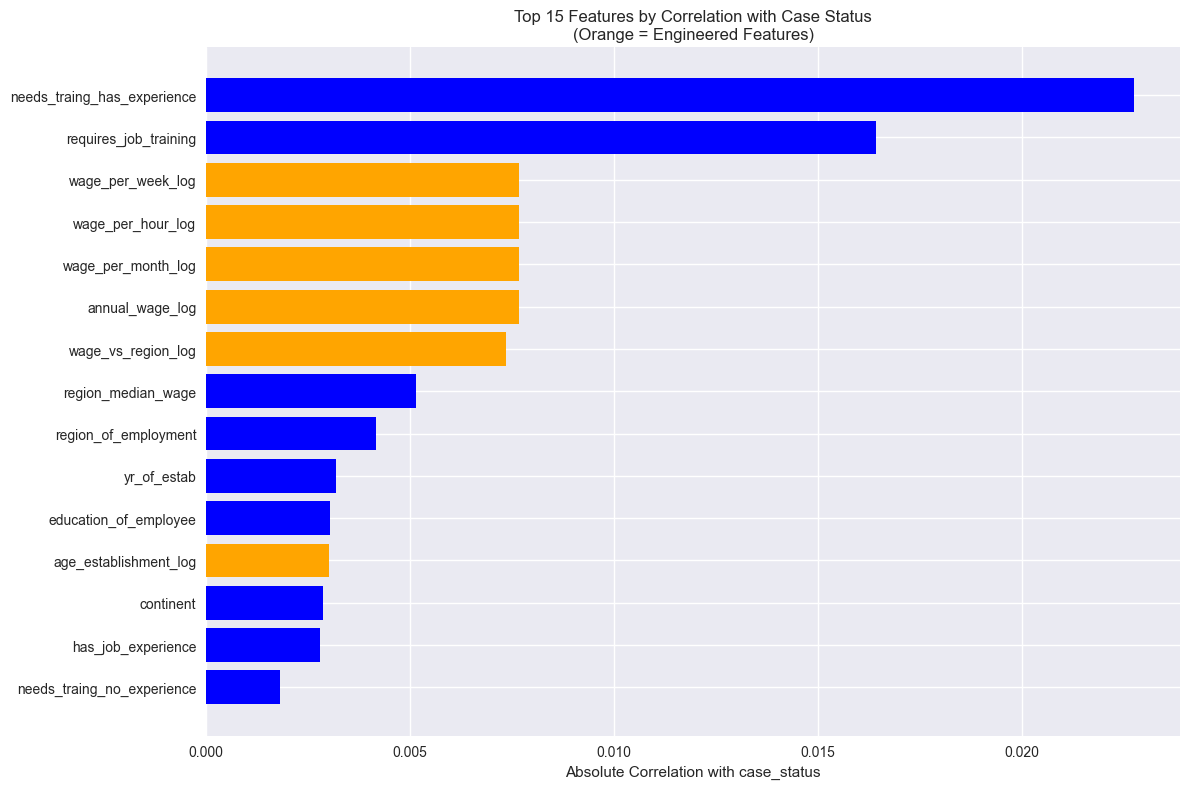


✓ Feature importance analysis completed
✓ 7 engineered features in top 10


In [28]:
# Feature importance analysis to validate EDA-based engineering
print("===FEATURE IMPORTANCE ANALYSIS===")
# Calculate correlation with target for all features
features_corr = easy_X_train_scaled.corrwith(easy_y_train).abs().sort_values(ascending=False)
print("Top 10 features by correlation with  Case Status")
for i, (feature, corr) in enumerate(features_corr.head(10).items(), 1):
    print(f"{i:2d}. {feature}: {corr:.3f}")
# Check if engineered features are among top features
engineered_features = [col for col in easy_X_train_scaled.columns if any(keyword in col.lower() for keyword in ['needs', 'log',"wage"])]
print(f"\nEngineered features in top 10: {[f for f in engineered_features if f in features_corr.head(10).index]}")
# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features = features_corr.head(15)
colors = ['orange' if any(keyword in f.lower() for keyword in ['year', 'total', 'log']) else 'blue' for f in top_features.index]
plt.barh(range(len(top_features)), top_features.values, color=colors)
plt.yticks(range(len(top_features)), top_features.index)
plt.xlabel('Absolute Correlation with case_status')
plt.title('Top 15 Features by Correlation with Case Status\n(Orange = Engineered Features)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
print(f"\n✓ Feature importance analysis completed")
print(f"✓ {len([f for f in engineered_features if f in features_corr.head(10).index])} engineered features in top 10")

#### **8. Saved preprocess Data**

In [29]:
print("SAVING PREPROCESSED DATA ")

# Save scaled datasets
easy_X_train_scaled.to_csv('easy_X_train_scaled.csv', index=False)
easy_X_test_scaled.to_csv('easy_X_test_scaled.csv', index=False)

# Save target variables
easy_y_train.to_csv('easy_y_train.csv', index=False)
easy_y_test.to_csv('easy_y_test.csv', index=False)

# Save preprocessing objects
import joblib
joblib.dump(easy_scaler, 'easy_scaler.pkl')
joblib.dump(easy_X.columns.tolist(), 'easy_selected_features.pkl')

# Save feature importance
easy_feature_importance_df = pd.DataFrame({
    'feature': features_corr.index,
    'correlation':features_corr.values
})
easy_feature_importance_df.to_csv('easy_feature_importance.csv', index=False)

# Save preprocessing summary
easy_preprocessing_summary = {
    'original_shape': df_copy.shape,
    'final_shape': df.shape,
    'selected_features': easy_X.columns.tolist(),
    'engineered_features': engineered_features,
    'train_samples': easy_X_train_scaled.shape[0],
    'test_samples':easy_X_train_scaled.shape[0],
    'scaling_method': 'RobustScaler',
    'outlier_treatment': 'Log Transformation',
    'log_transformed': ['annual_wage','wage_per_hour','wage_per_week','wage_per_month','wage_vs_region','age_establishment']
}

import json
with open('easy_preprocessing_summary.json', 'w') as f:
    json.dump(easy_preprocessing_summary, f, indent=2)

print("- Preprocessed data saved successfully!")
print("\nFiles created:")
print("- easy_X_train_scaled.csv, easy_X_test_scaled.csv")
print("- easy_y_train.csv, easy_y_test.csv")
print("- easy_scaler.pkl, easy_selected_features.pkl")
print("- easy_feature_importance.csv, easy_preprocessing_summary.json")

SAVING PREPROCESSED DATA 
- Preprocessed data saved successfully!

Files created:
- easy_X_train_scaled.csv, easy_X_test_scaled.csv
- easy_y_train.csv, easy_y_test.csv
- easy_scaler.pkl, easy_selected_features.pkl
- easy_feature_importance.csv, easy_preprocessing_summary.json


#### **9. Preprocessing Summary**

In [30]:
# Final preprocessing summary
print(".....PREPROCESSING SUMMARY BASED ON EDA INSIGHTS.....")
print(f"Original dataset shape: {df_copy.shape}")
print(f"Final processed dataset shape: {df.shape}")
print(f"Selected features: {len(easy_X)}")
print(f"Training samples: {easy_X_train_scaled.shape[0]}")
print(f"Test samples: {easy_X_test_scaled.shape[0]}")
print("\n.....PREPROCESSING STEPS COMPLETED (EDA-BASED).....")
print("> Data quality assessment (no missing values, no duplicated values)")
print("> Log-transformation of skewed variables ('annual_wage','wage_per_hour','wage_per_week', 'wage_per_month', 'age_of_estab', 'wage_vs_region')")
print("> Feature engineering based on EDA recommendations:")
print("- age_of_estab")
print("- annual_wage (wage_per_hour, wage_per_week, wage_per_month, wage_per_year)")
print("- need_training_has_exp")
print("- need_training_no_exp")
print("- region_median_wage")
print("- wage_vs_region.")
print("> Feature selection ('annual_wage','wage_per_hour','wage_per_week', 'wage_per_month', 'age_of_estab', 'wage_vs_region')")
print("> SMOTE (Handles class imbalance)")
print("> RobustScaler applied (EDA recommendation)")
print("> Feature importance analysis (validates engineered features)")
print("> Data export (ready for modeling)")
print("\n.....EDA EVIDENCE IMPLEMENTED.....")
print("> Skewed variables log-transformed as recommended")
print("> Features have been engineered")
print(f"\n Preprocessing completed successfully!!!!!!")
print(".....Ready for modeling phase with EDA-informed preprocessing")

.....PREPROCESSING SUMMARY BASED ON EDA INSIGHTS.....
Original dataset shape: (25480, 11)
Final processed dataset shape: (25480, 26)
Selected features: 34036
Training samples: 27228
Test samples: 6808

.....PREPROCESSING STEPS COMPLETED (EDA-BASED).....
> Data quality assessment (no missing values, no duplicated values)
> Log-transformation of skewed variables ('annual_wage','wage_per_hour','wage_per_week', 'wage_per_month', 'age_of_estab', 'wage_vs_region')
> Feature engineering based on EDA recommendations:
- age_of_estab
- annual_wage (wage_per_hour, wage_per_week, wage_per_month, wage_per_year)
- need_training_has_exp
- need_training_no_exp
- region_median_wage
- wage_vs_region.
> Feature selection ('annual_wage','wage_per_hour','wage_per_week', 'wage_per_month', 'age_of_estab', 'wage_vs_region')
> SMOTE (Handles class imbalance)
> RobustScaler applied (EDA recommendation)
> Feature importance analysis (validates engineered features)
> Data export (ready for modeling)

.....EDA EVI